# Analysis of models 

The following notebook will analyze the performance of our models as well as break down the feature importance of each model. After analyzing our results, we will discuss the results & find out if the project was succesful or not.

![](https://www.perth.ca/en/town-hall/resources/Images/COVID-19-banner.jpg)

## Dataset
The dataset we found via this [kaggle](https://www.kaggle.com/hemanthhari/symptoms-and-covid-presence) link contains information on patients who took the COVID-19 test. There is a total of 5434 rows & 21 columns. Each row corresponds to a patient's symptoms, where each column represent a symptom. In order to correctly pre-process the data, we removed features such as "contacted someone with the virus" or "recently travelled". The reason why is because we want to focus on tangible symptoms & see which symptoms indicate early stages of COVID-19. 

From the 5434 patients, 81% (4383) were later tested positive for the virus. Therefore, we needed to do something about the data imbalance.



## Imbalance
In order to tackle the imbalance problem of our dataset (81% of "yes", 19% of "no"), we decided to use imblearn's library. It gives us tools to sample data. We went for the oversampling method which will duplicate the minority a defined amount of time. We decided to oversample the minority to 50% of the number of the majority.

In [4]:
import imblearn

def oversample(filename, sampling = 0.5):
    '''
    The following function will oversample the data (duplicate the minority) to tackle our imbalance problem.
    '''
    
    # The following function will preprocess the data by limiting our dataset to only contain symptoms.
    X, y = preprocess_data(filename)
    
    # We use imblearn library to oversample the data 
    oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy = sampling)
    X_over, y_over = oversample.fit_resample(X, y)
    
    return X_over, y_over

### Imports

In [1]:
import numpy as np
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import models.utils as utils
import models.naive_bayes as gnb
import models.decision_tree as dt
import models.random_forest as rf
import models.support_vector_machine as svm
import models.neural_network as nn
import models.utils as utils
import models.preprocess as preprocess

## Preprocessing
The original data has two labels: yes & no. As mentionned earlier, we removed unwanted columns & also changed Yes's & No's to 1's & 0's. Once that is separated & ready to go, we split the training, validation & testing data into three partitions of 60%, 20% & 20% respectfully. Below is an example on how we preprocess our data & create a model with the sets described.


In [7]:
# Load data
DATA_FILE = utils.get_data_directory()
X, y = preprocess.preprocess_data(DATA_FILE)

# We split the training & testing set into partitions of 60% and 40%.
X_train, X_test, y_train, y_test = utils.split_data(X, y, 0.6)

# We split the validation & testing set into partitions of 50% and 50% from the original 40% test set.
X_val, X_test, y_val, y_test = utils.split_data(X_test, y_test, 0.5)

# We concatenate the training & validation set, create a separation boundary (-1 for train, 0 for validation)
X_partition = np.concatenate((X_train, X_val))
y_partition = np.concatenate((y_train, y_val))
separation_boundary = [-1 for _ in y_train] + [0 for _ in y_val]
ps = PredefinedSplit(separation_boundary)

# After defining a set of parameters, we train our model using the training set
# and tune the parameters with the validation set.
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'min_samples_split': [2, 4, 5, 10, 13],
    'min_samples_leaf': [1, 2, 5, 8, 13]
}

clf = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=ps)

Original dataset shape Counter({1: 4383, 0: 1051})


## 1. Gaussian Naive Bayes
In this section, we analyze the performance & feature importances of the GNB classifier. Initially, we will write a function we will use everything to display bar charts presenting the symptoms & their weight importance.

### 1.1 Feature Importance

In [3]:
def plt_bar_chart(features, weight, classifier, feat_type, yes, no):
    plt.barh(features, weight)
    plt.ylabel('Symptoms')
    plt.xlabel('Importance Weight')
    plt.title(f'{classifier} {feat_type} with size (Yes: {yes}, No: {no})')

Running Gaussian Naive Bayes...
Original dataset shape Counter({1: 4383, 0: 1051})


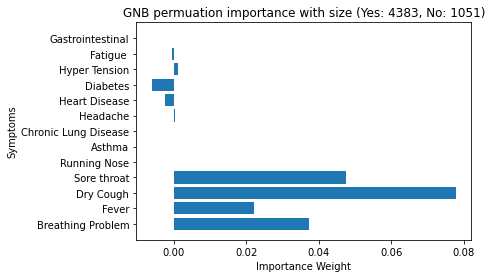

In [3]:
features = utils.get_feature_names()
feature_importances = sorted(gnb.naive_bayes(isNotebook = True))
_, weight = zip(*feature_importances)
plt_bar_chart(features, weight, "GNB", "permuation importance", 4383, 1051)

As we can see, the top three symptoms for the Naive Bayes model are:
- Dry cough
- Sore Throat
- Breathing Problems

Fever came close 3rd but we can see its weight is significantly higher than other symptoms. But, what do these numbers represent? 

##### Permutation Importance
If we look at GNB's in general, they do not naively have a ```feature_importances_``` output parameter like other models. Therefore, we used the notion of **permutation importance**. Permutation importance works by shuffling features. If shuffling a symptom made the model perform worse, then it suggests that this symptom is important. Therefore, it is assigned a postiive value.

#### Scaling up
Let's scale up the data to 1:2 & see the results

Running Gaussian Naive Bayes...
Original dataset shape Counter({1: 4383, 0: 1051})
Oversampled dataset shape Counter({1: 4383, 0: 2191})


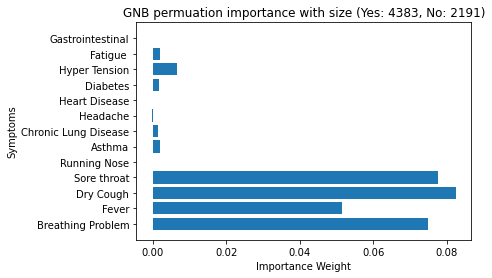

In [4]:
features = utils.get_feature_names()
feature_importances = sorted(gnb.naive_bayes(sampling = True, isNotebook = True))
_, weight = zip(*feature_importances)
plt_bar_chart(features, weight, "GNB", "permuation importance", 4383, 2191)

As we can see, the top three symptoms for the scaled up Naive Bayes model are:
- Breathing Problems
- Sore Throat
- Dry Cough

The order changed, but, the order does not matter in this case. As we can see, all features are scaled up but the symptoms remain the same.

### 1.2 Model performance
While the purpose of the project is to analyse feature importances, we thought it would be interesting to share how our models performed.

#### Confusion Matrix

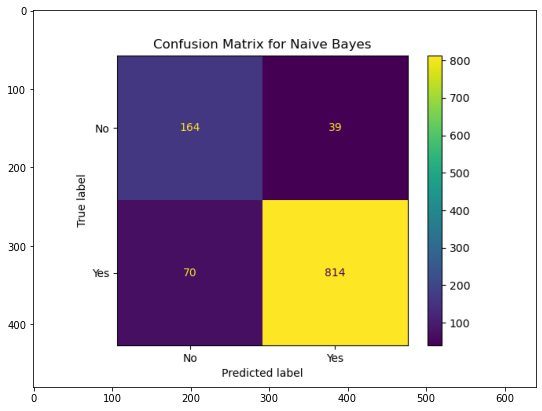

In [6]:
image = mpimg.imread("../results/GNB/confusion_matrix.png")
plt.figure(figsize = (9,9))
plt.imshow(image);

As we can see, there are 70 FN & 39 FP. Considering that GNB is a basic model, it's not bad as a baseline. Obviously, we seek to have a stronger model, we hope to achieve that with the fancier models ahead. In terms of metrics, the F1 score of negative cases came to 0.751 while the F1 score of positive cases is 0.937. 

Please note that **all metrics** observed are saved inside the ```results``` folder.

### 1.3 Conclusion
We did not expect the GNB to perform superbly & this was expected. The importance is that we got our three most important features which are **breathing problems, sore throat & dry cough**. 

## 2. Decision Tree
In this section, we analyze the performance & feature importances of the Decision Tree classifier.

### 2.1 Feature Importance


Running Decision Tree...
Original dataset shape Counter({1: 4383, 0: 1051})
====================Best parameters found====================
{'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}


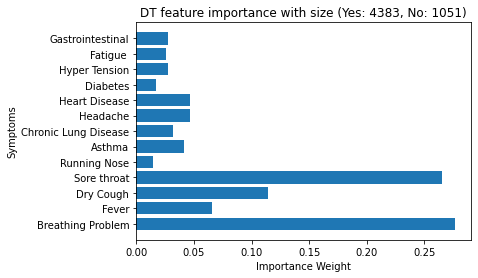

In [7]:
feature_tuples, best_model = dt.decision_tree(isNotebook = True)
features = utils.get_feature_names()
feature_importances = sorted(feature_tuples)
_, weight = zip(*feature_importances)
plt_bar_chart(features, weight, "DT", "feature importance", 4383, 1051)

print(f'{20*"="}Best parameters found{20*"="}')
print(best_model.best_params_)

As we can see, the top three symptoms for the Decision Tree model are:
- Breathing Problems
- Sore Throat
- Dry Cough

Fever came close 3rd again, but, unlike GNB, the other symptoms have more weight. In this case, we used Decision Tree's ```feature_importances_```. Let's take a look at our hyperparameters.

###### Hyperparameters
```
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'min_samples_split': [2, 4, 5, 10, 13],
    'min_samples_leaf': [1, 2, 5, 8, 13]
}
```
From the parameter grid, we used the validation set in order to find the best combination. In the end, it came out to be the following:

```
'splitter': 'best'
'min_samples_split': 4
'min_samples_leaf': 2
'criterion': 'gini'
```

#### Scaling up
Let's scale up the data to 1:2 & see the results


Running Decision Tree...
Original dataset shape Counter({1: 4383, 0: 1051})
Oversampled dataset shape Counter({1: 4383, 0: 2191})


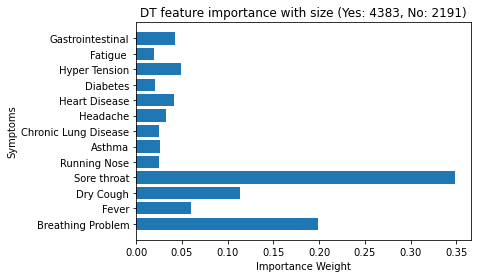

In [8]:
feature_tuples, best_model = dt.decision_tree(sampling = True, isNotebook = True)
features = utils.get_feature_names()
feature_importances = sorted(feature_tuples)
_, weight = zip(*feature_importances)
plt_bar_chart(features, weight, "DT", "feature importance", 4383, 2191)

As we can see, the top three symptoms for the scaled up Decision Tree model are:
- Breathing Problems
- Sore Throat
- Dry Cough

There is although an interesting shift in weight for the breathing problem & sore throat. After upscalling the data, we observe the sore throat importance increase while the breathing problems decrease. This suggests that having a sore throat is much more significant than having breathing problems. Let's verify this by upscaling to 3:4 rate.


Running Decision Tree...
Original dataset shape Counter({1: 4383, 0: 1051})
Oversampled dataset shape Counter({1: 4383, 0: 3287})


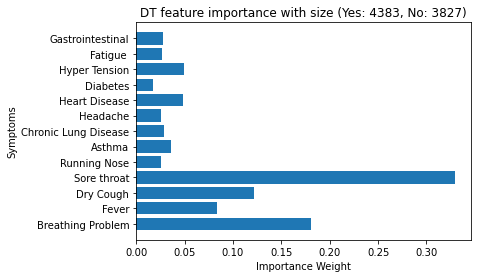

In [9]:
feature_tuples, best_model = dt.decision_tree(sampling = True, isNotebook = True, sampling_rate = 0.75)
features = utils.get_feature_names()
feature_importances = sorted(feature_tuples)
_, weight = zip(*feature_importances)
plt_bar_chart(features, weight, "DT", "feature importance", 4383, 3827)

Indeed, as we see, breathing problems' weight decreases while sore throat suggests that it is a critical feature upon making a prediction.

### 2.2 Model performance
We will look at how performing the decision tree turned out to be with hyperparameter tuning.

#### Confusion Matrix

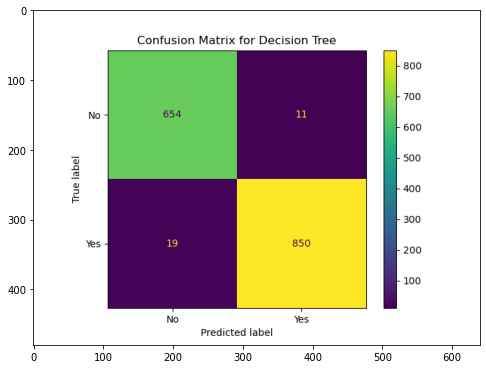

In [14]:
image = mpimg.imread("../results/DecisionTree/confusion_matrix.png")
plt.figure(figsize = (8,8))
plt.imshow(image);

As we can see, the Decision Tree performs much better than the GNB. Previously, there were 70 FN & 39 FP, now, we are at 19 FN & 11 FP. In terms of metrics, the F1 score of negative cases came to 0.978 while the F1 score of positive cases is 0.983. Considering the little amount of data we have, these are impressive figures!

### 2.3 Conclusion
The Decision Tree's most important features are **breathing problems, sore throat & dry cough**. So far, the symptoms agree with each other in each models we have visisted. Also, the decision tree's performance was excellent. 

## 3. Random Forest
In this section, we analyze the performance & feature importances of the Random Forest classifier.

### 3.1 Feature Importance

Running Random Forest...
Original dataset shape Counter({1: 4383, 0: 1051})


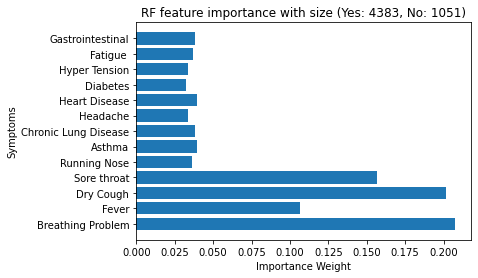

In [6]:
feature_tuples, best_model = rf.random_forest(isNotebook = True)
features = utils.get_feature_names()
feature_importances = sorted(feature_tuples)
_, weight = zip(*feature_importances)
plt_bar_chart(features, weight, "RF", "feature importance", 4383, 1051)

As we can see, the top three symptoms for the Decision Tree model are:
- Breathing Problems
- Dry Cough
- Sore Throat


The chart looks very similar to the decision tree we covered. Again, we used ```feature_importances_``` for Random Forests. 

###### Hyperparameters
```
param_grid = {
    'n_estimators': [100, 500, 1000],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 4, 5, 10, 13],
    'min_samples_leaf': [1, 2, 5, 8, 13]
}
```
From the parameter grid, we used the validation set in order to find the best combination. In the end, it came out to be the following:

```
'n_estimators': 500
'min_samples_split': 5
'min_samples_leaf': 2
'criterion': 'gini'
```

#### Scaling up
Let's scale up the data to 1:2 & see the results

Running Random Forest...
Original dataset shape Counter({1: 4383, 0: 1051})
Oversampled dataset shape Counter({1: 4383, 0: 2191})


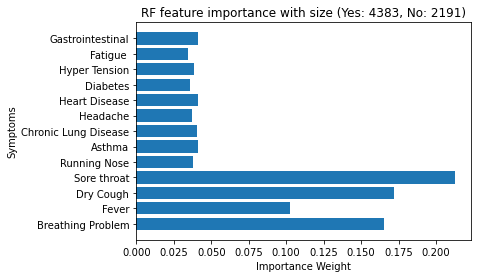

In [9]:
feature_tuples, best_model = rf.random_forest(sampling = True, isNotebook = True)
features = utils.get_feature_names()
feature_importances = sorted(feature_tuples)
_, weight = zip(*feature_importances)
plt_bar_chart(features, weight, "RF", "feature importance", 4383, 2191)

As we can see, the top three symptoms for the scaled up Random Forest model are:
- Dry Cough
- Breathing Problems
- Sore Throat

### 3.2 Model performance
We will look at how performing the random forest performed.

#### Confusion Matrix

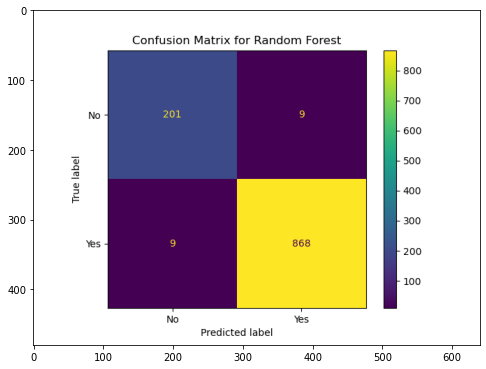

In [31]:
image = mpimg.imread("../results/Random Forest/confusion_matrix.png")
plt.figure(figsize = (8,8))
plt.imshow(image);

As we can see, the Random Forest performs much better than the Decision Tree. Previously, there were 19 FN & 11 FP, now, we are at 9 FN & 9 FP. In terms of metrics, the F1 score of negative cases came to 0.957 while the F1 score of positive cases is 0.99.

### 3.3 Conclusion
The Random Forest's most important features are **dry cough, breathing problems & sore throat**. So far, the symptoms agree with each other in each models we have visisted. Also, the Random Forest has been our best model thus far. So far, so good!

## 4. SVM
In this section, we analyze the performance & feature importances of the Support Vector Machine classifier.

### 4.1 Feature Importance

Running support vector machine...
Original dataset shape Counter({1: 4383, 0: 1051})
====================Best parameters found====================
{'C': 1.0, 'gamma': 0.01, 'kernel': 'linear'}


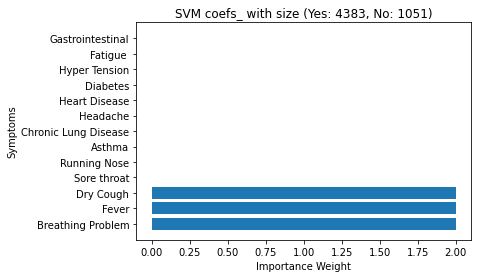

In [4]:
feature_tuples, best_model = svm.support_vector_machine(isNotebook = True)
features = utils.get_feature_names()
feature_importances = sorted(feature_tuples)
_, weight = zip(*feature_importances)
plt_bar_chart(features, weight, "SVM", "coefs_", 4383, 1051)

print(f'{20*"="}Best parameters found{20*"="}')
print(best_model.best_params_)

Hmm, odd results, right?

The top three symptoms for the SVM model are:
- Breathing Problems
- Fever
- Dry Cough

We have a new player, fever made the cut! But, we found it odd that the other symptomps have no significance. In this case, we are using SVM's ```coef_``` parameter to compare. Let's see how this parameter works.

###### coef_
It is generally hard to interpret a general kernel, but, for linear kernels, there is a little something we can do. In our case, the SVM outputs a hyperplane that separates both classes. The weights represented by ```coef_``` is a hyperplane orthogonal to the original separation bound. If the hyperplane finds one feature useful for seprarating the data, then the plane would be orthogonal to that axis. Therefore, one can assume that the coefficient represents how important it was when separating both sets of data.

###### Hyperparameters
```
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'min_samples_split': [2, 4, 5, 10, 13],
    'min_samples_leaf': [1, 2, 5, 8, 13]
}
```
From the parameter grid, we used the validation set in order to find the best combination. In the end, it came out to be the following:

```
'splitter': 'best'
'min_samples_split': 4
'min_samples_leaf': 2
'criterion': 'gini'
```

#### Scaling up
Let's scale up the data to 1:2 & see the results

Running support vector machine...
Original dataset shape Counter({1: 4383, 0: 1051})
Oversampled dataset shape Counter({1: 4383, 0: 2191})
====================Best parameters found====================
{'C': 1.0, 'gamma': 0.01, 'kernel': 'linear'}


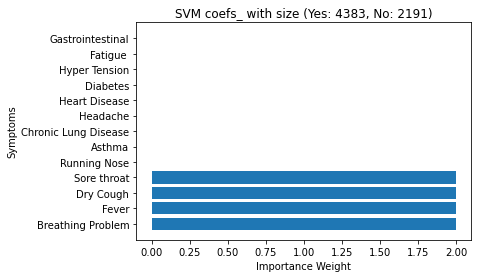

In [5]:
feature_tuples, best_model = svm.support_vector_machine(sampling = True, isNotebook = True)
features = utils.get_feature_names()
feature_importances = sorted(feature_tuples)
_, weight = zip(*feature_importances)
plt_bar_chart(features, weight, "SVM", "coefs_", 4383, 2191)

print(f'{20*"="}Best parameters found{20*"="}')
print(best_model.best_params_)

As we can see, the top three features are once again
- Breathing Problems
- Fever
- Dry Cough

Oversampling did not affect the dataset. We could keep going at this but we would just over-sample the data. For now, we will simply accept the results. Before going to the next step, let's showoff the weights of all features & understand the nature of the graph.

In [23]:
for i in range(len(feature_importances)):
    print(f'{features[feature_importances[i][0]]} | Weight: {round(feature_importances[i][1], 4)}')

Breathing Problem | Weight: 1.9997
Fever | Weight: 1.9995
Dry Cough | Weight: 1.9999
Sore throat | Weight: 0.0002
Running Nose | Weight: -0.0
Asthma | Weight: -0.0
Chronic Lung Disease | Weight: -0.0
Headache | Weight: 0.0001
Heart Disease | Weight: 0.0
Diabetes | Weight: 0.0
Hyper Tension | Weight: 0.0002
Fatigue  | Weight: -0.0001
Gastrointestinal | Weight: 0.0002


From the weights above, we see that the weights of all other features are very close to 0. 

### 4.2 Model performance
We will look at how performing the SVM perfomed.

#### Confusion Matrix

To our surprise, the SVM did not perform well. We believe this is due to the fact that our data is not easily seperable. There are 2^13 = 8192 different combinations possible for each patient. But, that's just talk. Let's plot the ROC curve & see what's going on.

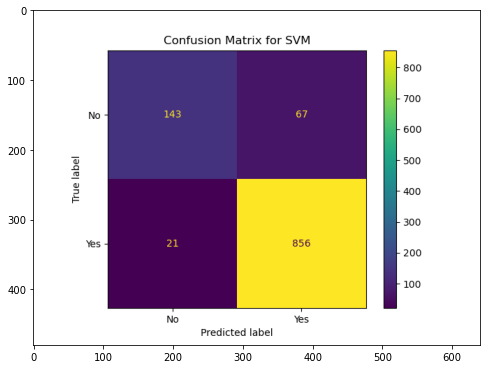

In [11]:
image = mpimg.imread("../results/SVM/confusion_matrix.png")
plt.figure(figsize = (8,8))
plt.imshow(image);

The model has a lot of false positives which suggests that we are mixing something that makes the model think a patient is COVID-19 positive. The numbers show that we have a **0.751 F1 score for NO cases** and **0.951 F1 score for YES cases**. Why is our model struggling with the negative cases?

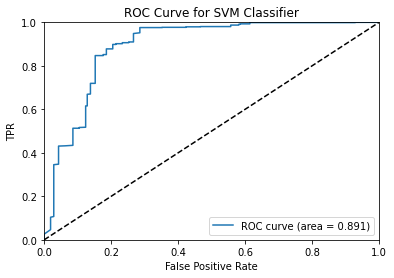

In [35]:
# metrics.plot_roc_curve(best_model, X_test, y_test)
probs = best_model.predict_proba(X_test)  
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs[: , 1])
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('TPR')
plt.title('ROC Curve for SVM Classifier')
plt.legend(loc="lower right")

Our understanding of the ROC curve displayed shows that we have a decent AUC value at 0.891. So, why is it that the F1 score finds itself to be low. Our model generated a performance file (as all other models do) & we noticed a big gap between precision & recall. The **precision is at 0.872** while the **recall is at 0.681.** 

We can increase recall by using different kernels. In this case, we only used a linear kernel in order to get feature importances which was the main goal of the project.

## 5. Neural Network
In this section, we analyze the performance & feature importances of the Neural Network classifier.

### 5.1 Feature Importance